# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')


# b. MNIST Data Loader

In [3]:
def binarize_image(tensor):
    return (tensor > 0.5).float()

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_image)
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. PixelCNN**


# a. Training Function

In [4]:
bce = F.binary_cross_entropy

def train(dataloader, model, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            tgt = images.clone()
            pred = model(images)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# b. Masked Convolution

In [5]:
class MaskedConv2d(nn.Conv2d):
    ##################
    ### Problem 2(a): Implement MaskedConv2d
    def __init__(self, input_num_c, output_num_c, kernel_size=5, padding=2, type='A'):

        # type == 'A' or type == 'B'
        # central_weight = 0 or central_weights = 1
        # self.maskedConv = torch.nn.Conv2d(input_num_c, output_num_c, kernel_size)
        super().__init__(input_num_c, output_num_c, [kernel_size, kernel_size], stride=1, padding=padding)
        h_masked_index = kernel_size // 2
        w_masked_index = kernel_size // 2
        self.mask = torch.ones_like(self.weight)
        self.mask[:,:, h_masked_index+1:, :] = 0.0
        if type == 'A':
          self.mask[:,:, h_masked_index , w_masked_index:] = 0.0
        elif type == 'B':
          self.mask[:,:, h_masked_index , w_masked_index+1:] = 0.0
        self.mask = self.mask.to(device)


    def forward(self, x):
        # print(self.weight.data.is_cuda)
        # print(self.mask.is_cuda)
        with torch.no_grad():
          self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)
    ##################


# c. Model

In [6]:
# class PixelCNN(nn.Module):
#     ##################
#     ### Problem 2(b): Implement PixelCNN
#     def __init__(self, imgH, imgW, num_input_c=3, num_inner_c=128, num_output_c=3, num_masked_convs=8):
#         super(PixelCNN, self).__init__()
#         net = []

#         net.append(MaskedConv2d(num_input_c, num_inner_c, 5, 'A', device))
#         net.append(torch.nn.LeakyReLU(0.1))
#         net.append(torch.nn.LayerNorm([num_inner_c, imgH, imgW]))


#         for i in range(num_masked_convs):
#           net.append(MaskedConv2d(num_inner_c, num_inner_c, 5, 'B', device))
#           net.append(torch.nn.LeakyReLU(0.1))
#           net.append(torch.nn.LayerNorm([num_inner_c, imgH, imgW]))

#         net.append(MaskedConv2d(num_inner_c, num_output_c, 5, 'A', device))
#         net.append(torch.nn.Sigmoid())

#         self.net = torch.nn.Sequential(*net)

#     def forward(self, x):
#         x = self.net(x)
#         return x
#     ##################




# # ori version
# class PixelCNN(nn.Module):
#     ##################
#     ### Problem 2(b): Implement PixelCNN
#     def __init__(self, num_input_c=3, num_inner_c=64, num_output_c=3, num_masked_convs=4):
#         super(PixelCNN, self).__init__()
#         net = []

#         net.append(MaskedConv2d(num_input_c, num_inner_c, 5, 'A'))
#         net.append(torch.nn.LeakyReLU(0.1))
#         net.append(torch.nn.BatchNorm2d([num_inner_c]))


#         for i in range(num_masked_convs):
#           net.append(MaskedConv2d(num_inner_c, num_inner_c, 5, 'B'))
#           net.append(torch.nn.LeakyReLU(0.1))
#           net.append(torch.nn.BatchNorm2d([num_inner_c]))

#         net.append(MaskedConv2d(num_inner_c, num_output_c, 5, 'A'))
#         net.append(torch.nn.Sigmoid())

#         self.net = torch.nn.Sequential(*net)

#     def forward(self, x):
#         x = self.net(x)
#         return x
#     ##################

class residualMaskedConv(nn.Module):
    def __init__(self, input_num_dim, output_num_dim):
        super().__init__()

        net = []
        net.append(torch.nn.Conv2d(input_num_dim, input_num_dim // 2, 1))
        net.append(torch.nn.ReLU())
        net.append(MaskedConv2d(input_num_dim // 2, input_num_dim // 2, 3, padding=1, type='B'))
        net.append(torch.nn.ReLU())
        net.append(torch.nn.Conv2d(input_num_dim // 2, output_num_dim, 1))
        net.append(torch.nn.ReLU())
        self.net = torch.nn.Sequential(*net)
    
    def forward(self, x):
        x = x + self.net(x)
        return x



class PixelCNN(nn.Module):
    ##################
    ### Problem 2(b): Implement PixelCNN
    def __init__(self, num_input_c=1, num_inner_c=64, num_output_c=1, num_masked_convs=4):
        super(PixelCNN, self).__init__()
        
        shallow_fea = []
        shallow_fea.append(MaskedConv2d(num_input_c, num_inner_c, 7, 3, 'A'))
        shallow_fea.append(torch.nn.LeakyReLU(0.1))


        net = []
        for i in range(num_masked_convs):
          net.append(residualMaskedConv(num_inner_c, num_inner_c))


        final_fea = []
        final_fea.append(MaskedConv2d(num_inner_c, num_inner_c, 1, 0, 'B'))
        final_fea.append(torch.nn.LeakyReLU(0.1))
        final_fea.append(MaskedConv2d(num_inner_c, num_output_c, 1, 0, 'B'))
        final_fea.append(torch.nn.Sigmoid())

        self.sf = torch.nn.Sequential(*shallow_fea)
        self.net = torch.nn.Sequential(*net)
        self.ff = torch.nn.Sequential(*final_fea)

    def forward(self, x):

        x = self.sf(x)
        x = x + self.net(x)
        x = self.ff(x)
        return x
    ##################

# d. Training

In [10]:
##################
### Problem 2(c): Training
# epochs = 100
# model = PixelCNN().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# log = train(train_loader, model, optimizer, epochs)


epochs = 2
model = PixelCNN(1, 64, 1).to(device)
print(model)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

log = train(train_loader, model, optimizer, epochs)


##################


PixelCNN(
  (sf): Sequential(
    (0): MaskedConv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (net): Sequential(
    (0): residualMaskedConv(
      (net): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): MaskedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (5): ReLU()
      )
    )
    (1): residualMaskedConv(
      (net): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): MaskedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (5): ReLU()
      )
    )
    (2): residualMaskedConv(
      (net): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2)

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----Epoch [1/2], Average Loss: 0.1035



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----Epoch [2/2], Average Loss: 0.0917



# e. Evaluation (Reconstruction)

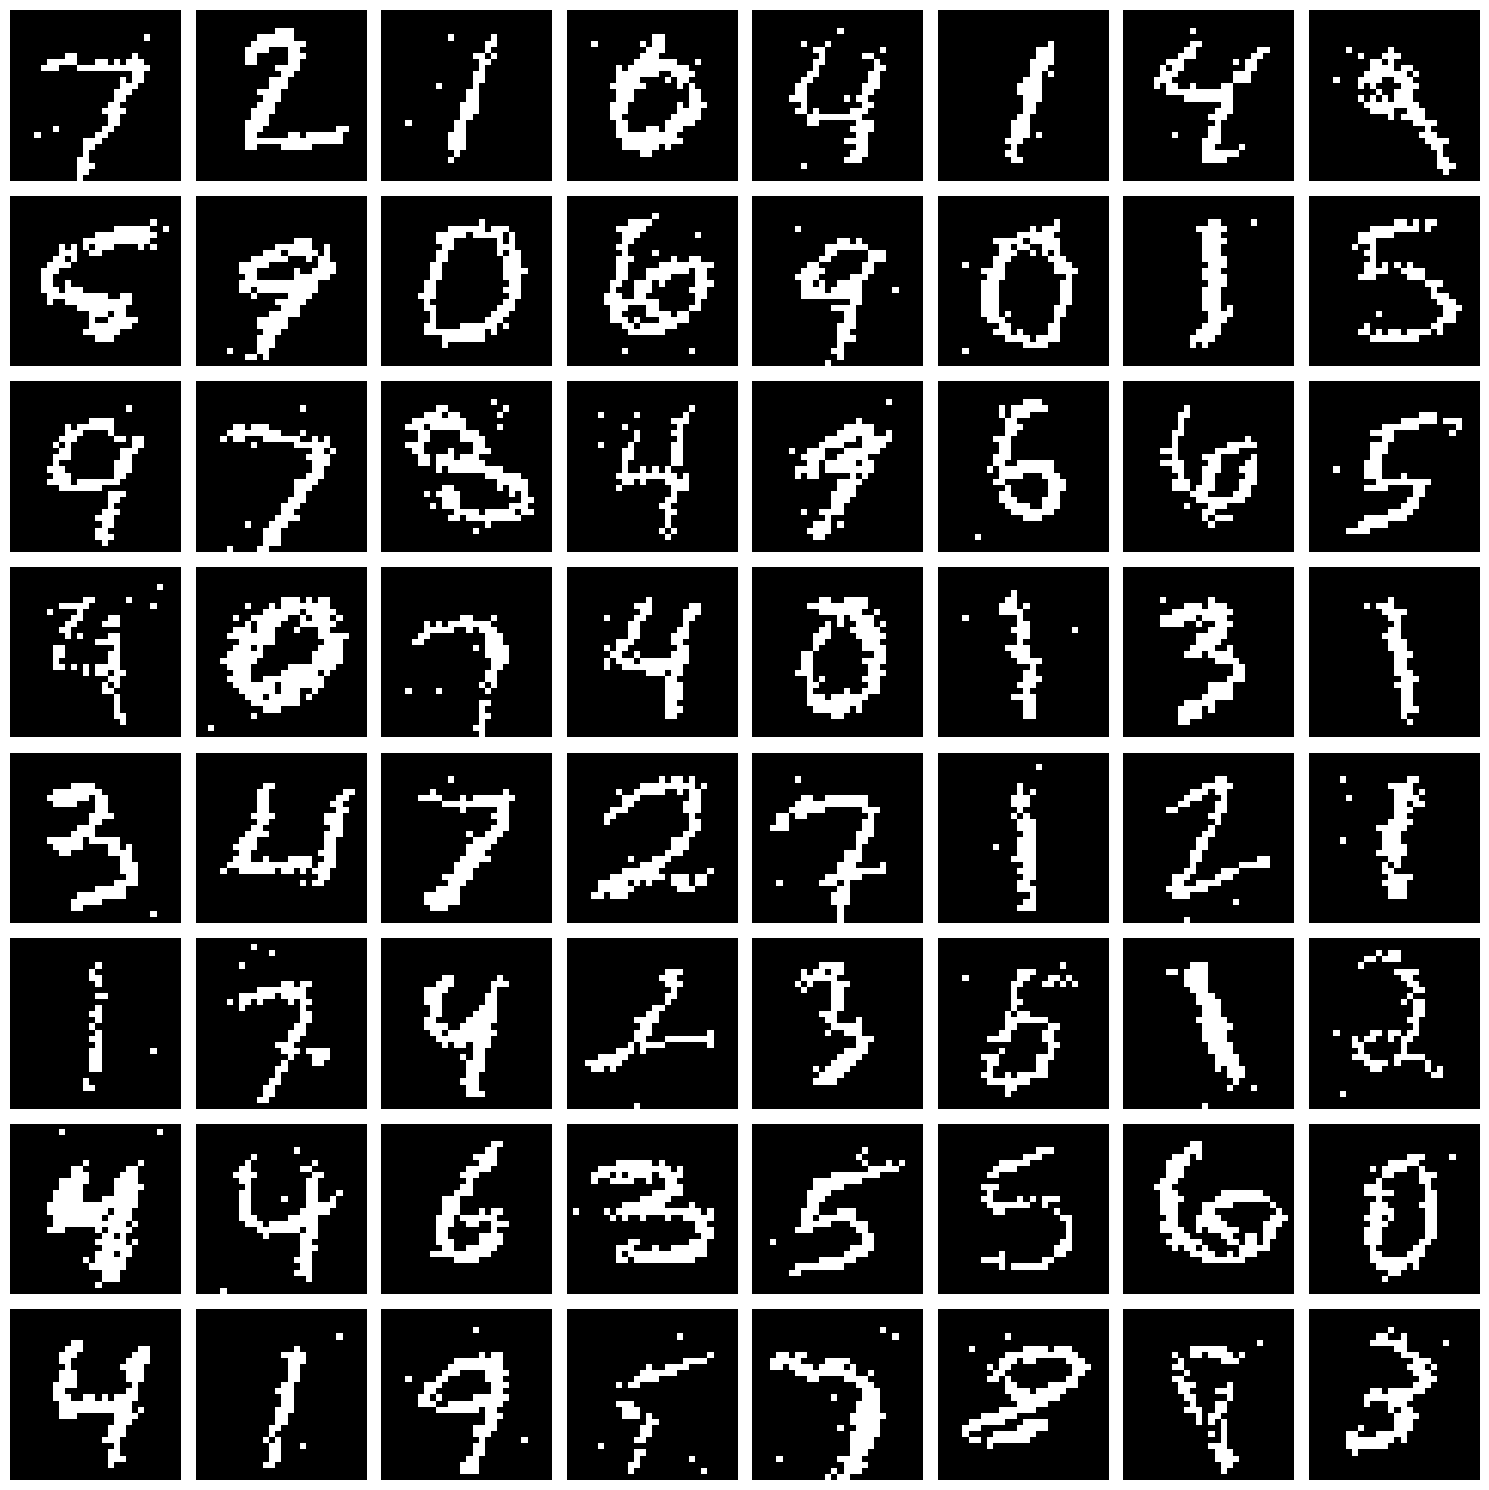

In [8]:
H, W = 28, 28
model.eval()
with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      pred = model(images)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

In [14]:
samples = torch.zeros(size=(64, 1, H, W)).to(device)
# samples = torch.ones(size=(64, 1, H, W)).to(device)
with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(out[0, :, :, :].cpu().numpy().transpose(2, 1, 0), 'gray')

# **2. Conditional PixelCNN**


# a. Training Function

In [14]:
def train_cond(dataloader, model, optimizer, epochs, n_classes):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            labels = labels.to(device)
            tgt = images.clone()
            labels = F.one_hot(labels, num_classes=n_classes).float()
            pred = model(images, labels)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses

# b. Conditional Masked Convolution

In [15]:
class ConditionalMaskedConv2d(MaskedConv2d):
    ##################
    ### Problem 3(b): Implement ConditionalMaskedConv2d
    def __init__(self, input_num_c, output_num_c, kernel_size=5, padding=2, type='A'):
        super().__init__(input_num_c, output_num_c, kernel_size=kernel_size, padding=padding, type=type)
        # h_masked_index = kernel_size // 2
        # w_masked_index = kernel_size // 2
        # self.mask = torch.ones_like(self.weight)
        # self.mask[:,:, h_masked_index+1:, :] = 0.0
        # if type == 'A':
        #   self.mask[:,:, h_masked_index , w_masked_index:] = 0.0
        # elif type == 'B':
        #   self.mask[:,:, h_masked_index , w_masked_index+1:] = 0.0
        self.mask = self.mask.to(device)

        self.h_func = torch.nn.Linear(10, 28 * 28).to(device)
        self.to(device)

    def forward(self, x, class_condition):
        vh = self.h_func(class_condition).view(-1, 1, 28, 28)
        return super(ConditionalMaskedConv2d, self).forward(x) + vh
    ##################


class residualConditionalMaskedConv(nn.Module):
    def __init__(self, input_num_dim, output_num_dim):
        super().__init__()

        net0 = []
        net0.append(torch.nn.Conv2d(input_num_dim, input_num_dim // 2, 1))
        net0.append(torch.nn.ReLU())
        
        self.conv0 = ConditionalMaskedConv2d(input_num_dim // 2, input_num_dim // 2, 3, padding=1, type='B')
        self.relu0 = torch.nn.ReLU()

        net2 = []
        net2.append(torch.nn.Conv2d(input_num_dim // 2, output_num_dim, 1))
        net2.append(torch.nn.ReLU())

        self.net0 = torch.nn.Sequential(*net0)
        # self.net1 = torch.nn.Sequential(*net1)
        self.net2 = torch.nn.Sequential(*net2)
        self.to(device)
    
    def forward(self, x, class_condition):
        x = x + self.net2(self.relu0(self.conv0(self.net0(x), class_condition)))
        return x
    


# with torch.no_grad():
#     rcmconv = residualConditionalMaskedConv(16, 16).to(device)
#     test_tensor = torch.zeros([2, 16, 28, 28]).to(device)
#     class_condition = torch.tensor([6,5]).to(device)
#     class_condition = F.one_hot(class_condition, num_classes=10).float()
#     output = rcmconv(test_tensor, class_condition)
#     print(output.shape)


# c. Model

In [23]:
class ConditionalPixelCNN(nn.Module):
    ##################
    ### Problem 3(b): Implement ConditionalPixelCNN
    def __init__(self, num_input_c=3, num_inner_c=64, num_output_c=3, num_masked_convs=4):
        super(ConditionalPixelCNN, self).__init__()

        self.num_masked_convs = num_masked_convs
        
        self.shallow_fea = torch.nn.ModuleList([])
        self.shallow_fea.append(ConditionalMaskedConv2d(num_input_c, num_inner_c, 7, 3, 'A'))
        self.shallow_fea.append(torch.nn.LeakyReLU(0.1))


        self.resCMConvNet = torch.nn.ModuleList([])
        for i in range(num_masked_convs):
          self.resCMConvNet.append(residualConditionalMaskedConv(num_inner_c, num_inner_c))


        self.final_fea_conv0 = torch.nn.ModuleList([])
        self.final_fea_conv0.append(ConditionalMaskedConv2d(num_inner_c, num_inner_c, 1, 0, 'B'))
        self.final_fea_conv0.append(torch.nn.LeakyReLU(0.1))


        self.final_fea_conv1 = torch.nn.ModuleList([])
        self.final_fea_conv1.append(ConditionalMaskedConv2d(num_inner_c, 1, 1, 0, 'B'))
        self.final_fea_conv1.append(torch.nn.Sigmoid())
        

        # self.sf = torch.nn.Sequential(*shallow_fea)
        # self.net = torch.nn.Sequential(*resCMConvNet)
        # self.ff = torch.nn.Sequential(*self.final_fea_conv1)
        self.to(device)

    def forward(self, x, class_condition):

        # x = self.sf(x, class_condition)
        # x = x + self.net(x, class_condition)
        # x = self.ff(x, class_condition)

        x = self.shallow_fea[0](x, class_condition)
        x = self.shallow_fea[1](x)
        x_sf = torch.clone(x)
        for i in range(self.num_masked_convs):
            x_sf = self.resCMConvNet[i](x_sf, class_condition)
        x = x + x_sf

        x = self.final_fea_conv0[0](x, class_condition)
        x = self.final_fea_conv0[1](x)
        x = self.final_fea_conv1[0](x, class_condition)
        x = self.final_fea_conv1[1](x)

        return x

# d. Training

In [25]:
##################
epochs = 100
### Problem 3(c): Training
n_classes = 10
model = ConditionalPixelCNN(1, 64, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train_cond(train_loader, model, optimizer, epochs, n_classes)
##################


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [1/100], Average Loss: 0.1255



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [2/100], Average Loss: 0.0846



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [3/100], Average Loss: 0.0813



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [4/100], Average Loss: 0.0794



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [5/100], Average Loss: 0.0783



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [6/100], Average Loss: 0.0774



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [7/100], Average Loss: 0.0768



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [8/100], Average Loss: 0.0763



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [9/100], Average Loss: 0.0758



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [10/100], Average Loss: 0.0755



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [11/100], Average Loss: 0.0752



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [12/100], Average Loss: 0.0750



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [13/100], Average Loss: 0.0747



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [14/100], Average Loss: 0.0745



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [15/100], Average Loss: 0.0743



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [16/100], Average Loss: 0.0742



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [17/100], Average Loss: 0.0740



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [18/100], Average Loss: 0.0739



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [19/100], Average Loss: 0.0737



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [20/100], Average Loss: 0.0736



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [21/100], Average Loss: 0.0735



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [22/100], Average Loss: 0.0734



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [23/100], Average Loss: 0.0734



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [24/100], Average Loss: 0.0732



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [25/100], Average Loss: 0.0731



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [26/100], Average Loss: 0.0731



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [27/100], Average Loss: 0.0730



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [28/100], Average Loss: 0.0729



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [29/100], Average Loss: 0.0728



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [30/100], Average Loss: 0.0727



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [31/100], Average Loss: 0.0727



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [32/100], Average Loss: 0.0726



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [33/100], Average Loss: 0.0726



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [34/100], Average Loss: 0.0725



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [35/100], Average Loss: 0.0724



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [36/100], Average Loss: 0.0724



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [37/100], Average Loss: 0.0724



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [38/100], Average Loss: 0.0723



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [39/100], Average Loss: 0.0723



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [40/100], Average Loss: 0.0722



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [41/100], Average Loss: 0.0722



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [42/100], Average Loss: 0.0721



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [43/100], Average Loss: 0.0721



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [44/100], Average Loss: 0.0721



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [45/100], Average Loss: 0.0720



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [46/100], Average Loss: 0.0720



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [47/100], Average Loss: 0.0719



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [48/100], Average Loss: 0.0719



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [49/100], Average Loss: 0.0719



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [50/100], Average Loss: 0.0718



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [51/100], Average Loss: 0.0718



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [52/100], Average Loss: 0.0717



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [53/100], Average Loss: 0.0717



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [54/100], Average Loss: 0.0717



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [55/100], Average Loss: 0.0716



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [56/100], Average Loss: 0.0717



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [57/100], Average Loss: 0.0716



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [58/100], Average Loss: 0.0716



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [59/100], Average Loss: 0.0716



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [60/100], Average Loss: 0.0715



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [61/100], Average Loss: 0.0715



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [62/100], Average Loss: 0.0715



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [63/100], Average Loss: 0.0715



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [64/100], Average Loss: 0.0714



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [65/100], Average Loss: 0.0714



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [66/100], Average Loss: 0.0714



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [67/100], Average Loss: 0.0714



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [68/100], Average Loss: 0.0714



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [69/100], Average Loss: 0.0713



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [70/100], Average Loss: 0.0713



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [71/100], Average Loss: 0.0713



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [72/100], Average Loss: 0.0713



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [73/100], Average Loss: 0.0713



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [74/100], Average Loss: 0.0712



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [75/100], Average Loss: 0.0712



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [76/100], Average Loss: 0.0712



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [77/100], Average Loss: 0.0712



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [78/100], Average Loss: 0.0712



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [79/100], Average Loss: 0.0712



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [80/100], Average Loss: 0.0712



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [81/100], Average Loss: 0.0711



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [82/100], Average Loss: 0.0711



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [83/100], Average Loss: 0.0711



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [84/100], Average Loss: 0.0711



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [85/100], Average Loss: 0.0710



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [86/100], Average Loss: 0.0711



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [87/100], Average Loss: 0.0710



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [88/100], Average Loss: 0.0710



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [89/100], Average Loss: 0.0710



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [90/100], Average Loss: 0.0710



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [91/100], Average Loss: 0.0710



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [92/100], Average Loss: 0.0710



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [93/100], Average Loss: 0.0710



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [94/100], Average Loss: 0.0710



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [95/100], Average Loss: 0.0709



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [96/100], Average Loss: 0.0709



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [97/100], Average Loss: 0.0709



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [98/100], Average Loss: 0.0709



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [99/100], Average Loss: 0.0709



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [100/100], Average Loss: 0.0709



# e. Evaluation (Reconstruction)

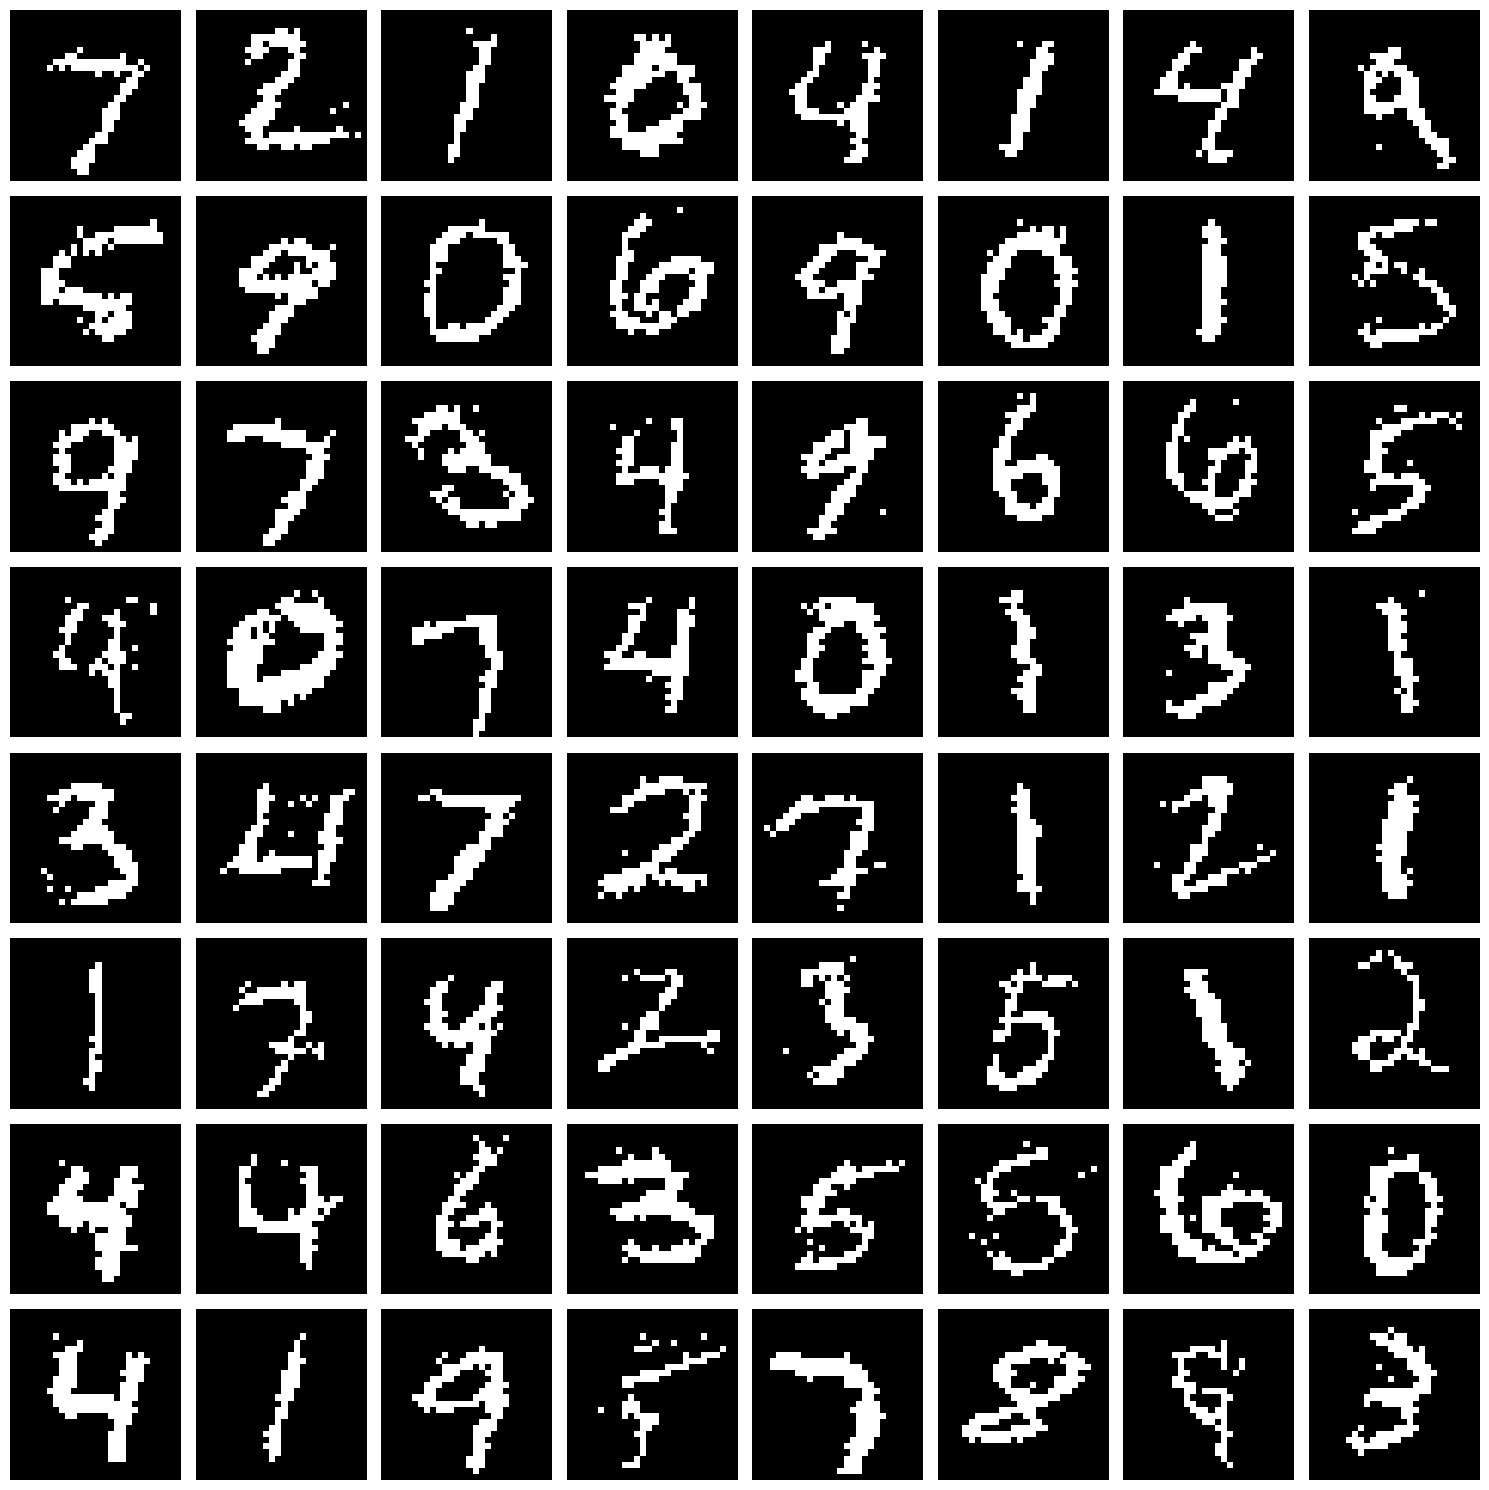

In [26]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      labels = F.one_hot(labels, num_classes=n_classes).float()
      pred = model(images, labels)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

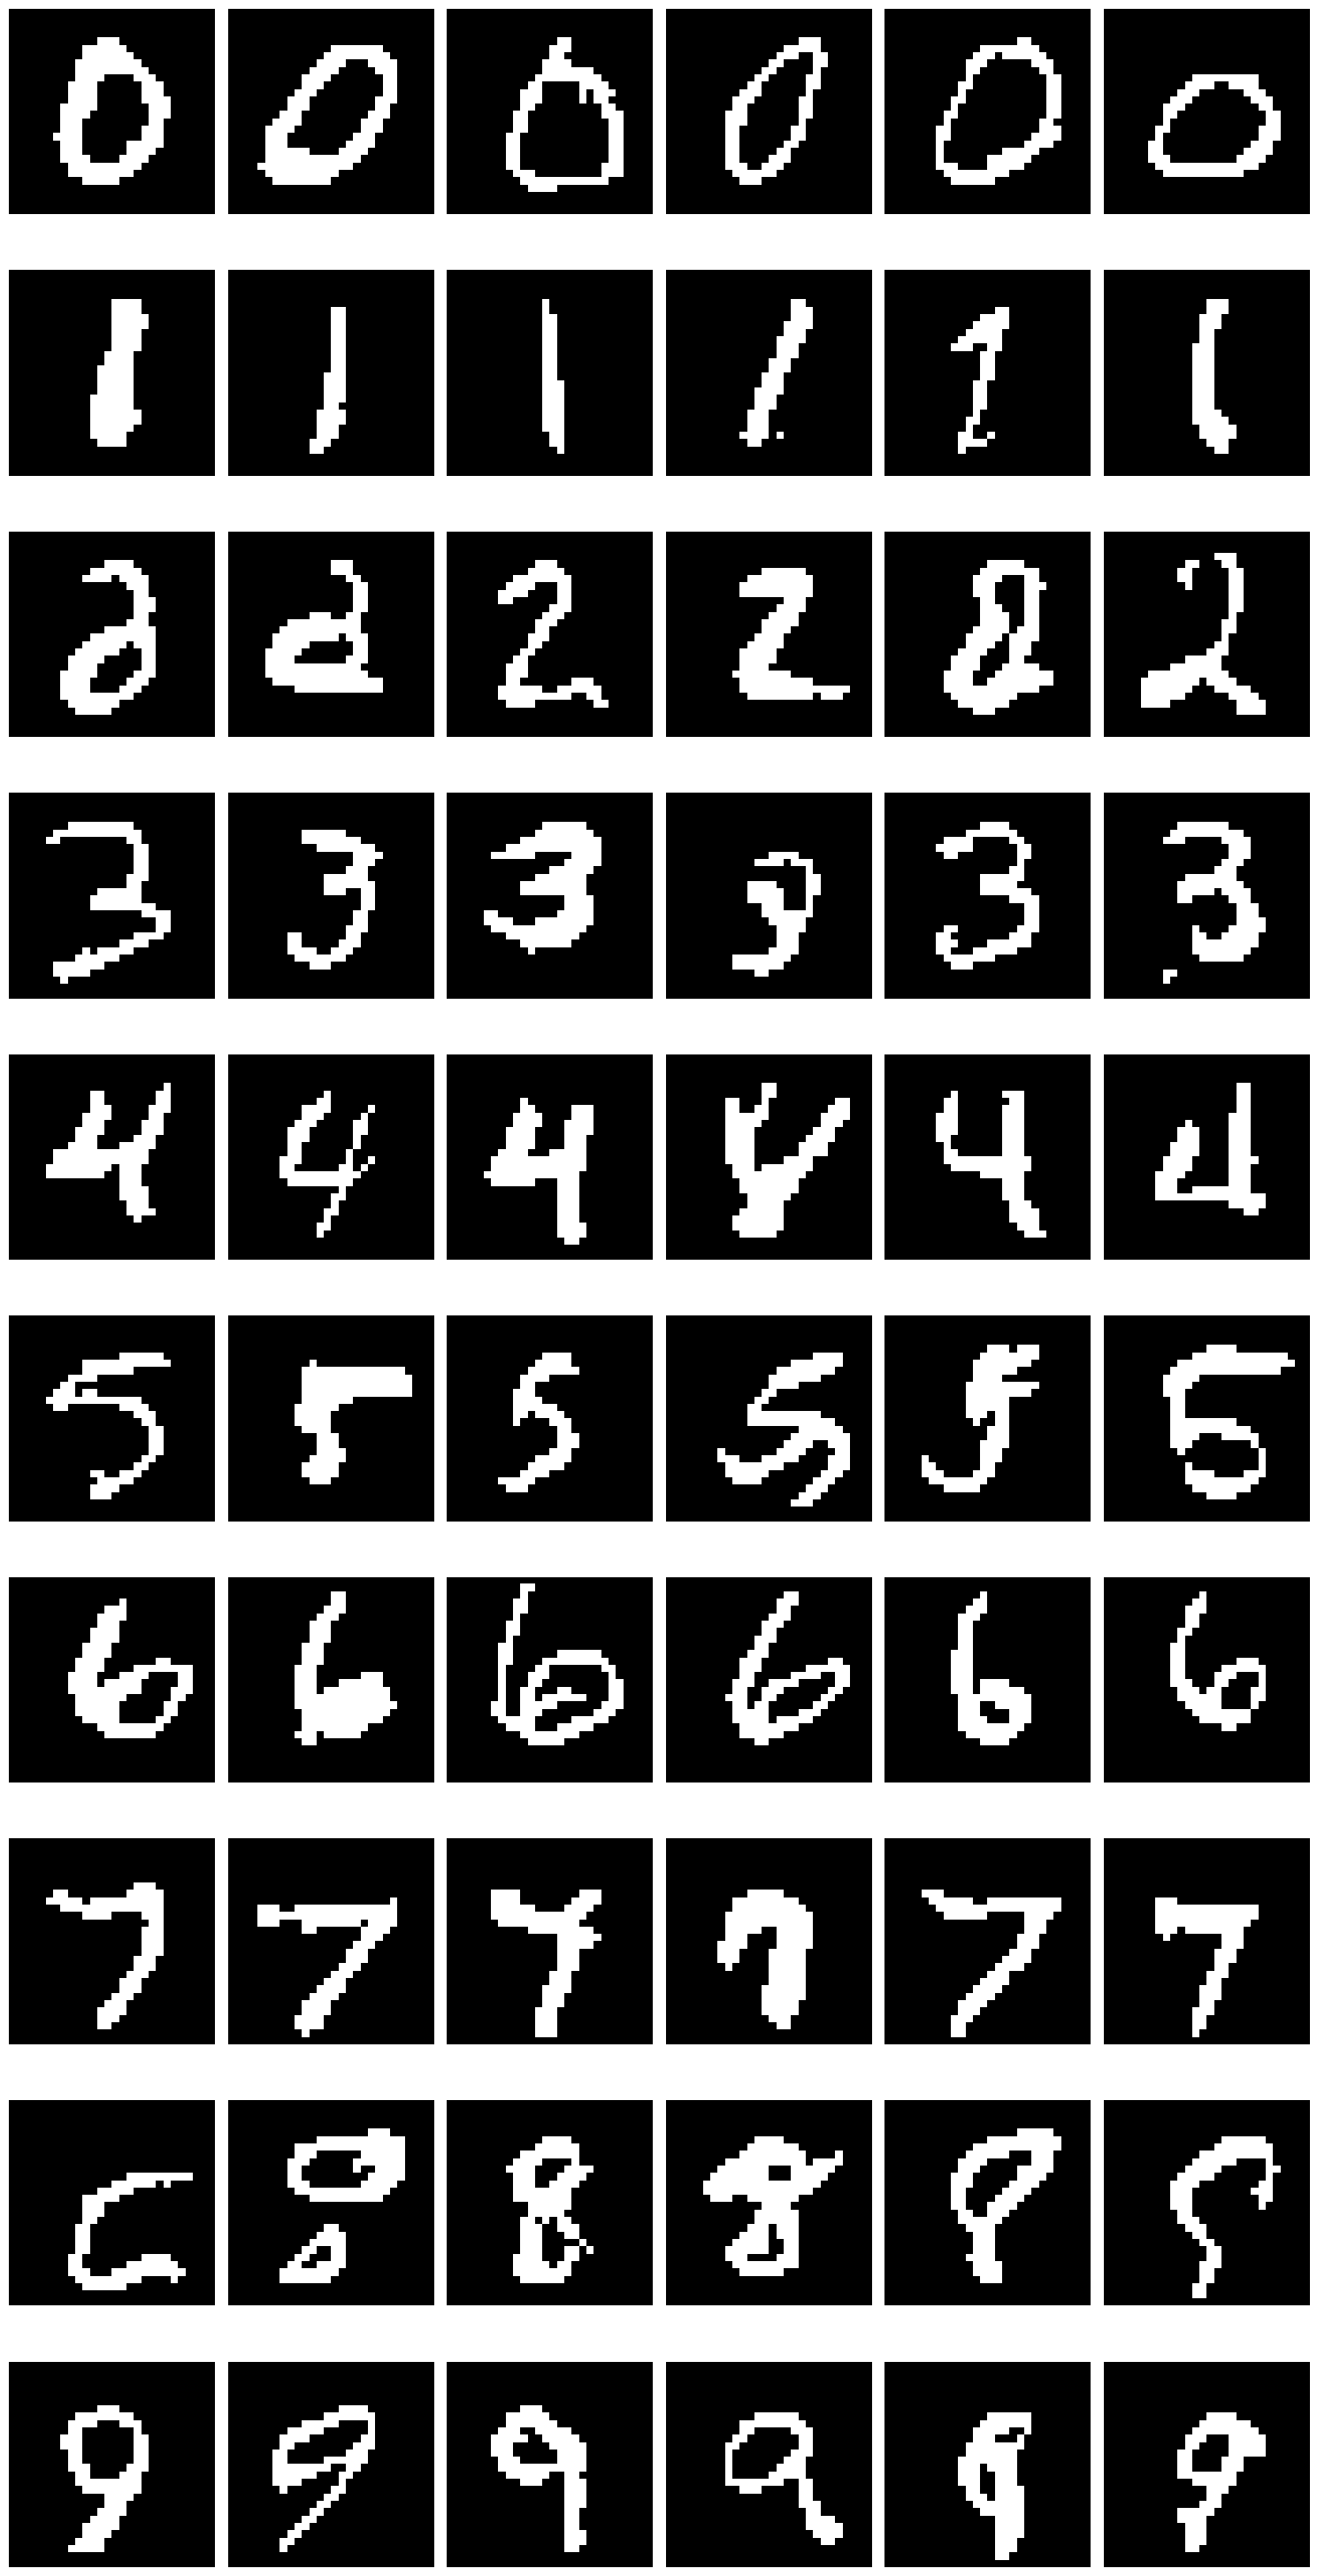

In [27]:
samples = torch.zeros(size=(60, 1, H, W)).to(device)
sample_classes = np.sort(np.array([np.arange(n_classes)] * 6).flatten())
sample_classes = F.one_hot(torch.tensor(sample_classes), num_classes=n_classes).to(device).float()

with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples, sample_classes)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(10, 6, figsize=(15, 30))

for i in range(60):
    sample = samples[i]
    row, col = divmod(i, 6)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()